# Supervised Bayesian ISE(Ion-Selective Electrodes) Calibration

### Description of the problem
We have a solution containng $n_s$ ions anf an array of $n_c$ electrodes. We want to measure the activity(or concentration) of each of the ions using sensors called Ion Selective Electrodes(ISE). Each ISE is selective to a particular ion. The response of $i^{th}$ ISE within the array at the instant $t$ is given by $y_{it}$. This response is measured in volts. The response of an ISE is not only dependent on the activity of its target ion, $s_{it}$, but also on the activities of the other ions in the solution, $s_{jt}$. According to Nicolsky-Eisenman equation, this process can be modeled as:

$y_{it} = e_{i} + d_i log \Big(s_{it} + \sum_{j=1,i\neq j}^{n_s}a_{ij}s_{jt}^{z_{i}/z_{}j} \Big)$

where,

- $e_i$ is a constant representing the electrode potential of the ISE
- $z_j$ is the valence of the j-th ion
- $a_{ij}$ is the selectivity coefficient of the j-th ion (meaning we are using ISE selective to j-th ion) to i-th ion
- $d_i = RT/z_iF$ where, R is the gas constant, F is the Faraday's constant and T is the temperature in Kelvin

Stacking $y_{it}$ for each $t$ and vectorizing gives the following matrix equation:

$Y = E\cdot \mathbf{1}_{1\times n_d} + diag(d)log(AS)$

where,

- $Y \in \mathbf{R}^{n_c \times n_d}$
- $E = [e_1,...,e_{n_c}]^\top$
- $d = d_1,...,d_{n_c}^\top$
- $A \in \mathbf{R}_{+}^{n_c\times n_s}$
- $S \in \mathbf{R}_{+}^{n_s\times n_d}$

### Approach: Supervised Bayesian Calibration of ISE

In this scenario, we are given some measurements of s_{jt} at some time instants t and the corresponding response of the ith electrode at the same time instant. We will then use this data to infer the unknown parameters of the model: $E, d, A$.

We will set up resonable prior on the distribution of the unknown parameters as follows:

- $A$ is the selectivity coefficients of the senosrs and they have to be non negative numbers. We will choose it to be unifromly distributed between 0 and 1:
$A$ ~ $Uniform(0,1)$

- each $d_i$ is actually deterministic and takes the value $0.059/z_i$ where $z_i$ is the valance of the ith ion. But due to manufacturing fabrication processes it is not exactly this number but is close to it. So the prior for $d_i$ is: <br>
$d_i$ ~ $Normal(0.059/z_i, \sigma_{d_i})$ where $\sigma_{d_i}$ must be large enough to model the manufacturing variations.

- $e_i$ is also due to manifacturing variations and typically has a value in the interval [0.05, 0.35] so we can choose our prior as:<br>
$e_i$ ~ $Normal(0.2, \sigma_{e_i})$  where, $\sigma_{e_i}$ is chosen accordingly.

#### Likelihood

The likelihood for th mode is as follows: <br>

$Y = E\cdot \mathbf{1}_{1\times n_d} + diag(d)log(AS) + \epsilon$, $\quad$ where $\epsilon$ ~ $Normal(0,\sigma)$

Uisng the prior and the likelihood we can then fidn the posterior using Baye's theorem. This is the basic idea behind Bayesian ISE Calibration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Create simulated dataset based on real parameter values

The parameters used to generate these data can be found in:

Y. Umezawa, P. Buhlmann, K. Umezawa, K. Tohda, and S. Amemiya, ¨
“Potentiometric selectivity coefficients of ion-selective electrodes,” Pure
and Applied Chemistry, vol. 72, pp. 1851–2082, 2000.


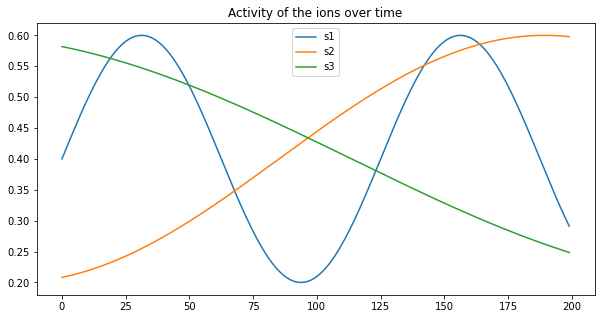

In [245]:
num_samples = 200   #total samples 
num_electrodes = 3
num_sources = 3     #number of interacting ions in the solution
AA = np.array([[1, 0.16, 0.40], [0.25, 1, 0.19], [0.40, 0.13, 1]])  #selectivity coeffs
d = [[0.059], [0.050], [0.055]]     
e = [[0.095], [0.105], [0.110]]

#give a temporal envelop to the data
s1 = (2 + np.sin(np.linspace(0,10, num_samples)))*0.2
s2 = (2 + np.sin(np.linspace(5,8, num_samples)))*0.2
s3 = (2 + np.sin(np.linspace(2,4, num_samples)))*0.2

S_comb = np.power([s1,s2,s3],1)
plt.figure(figsize=(10,5))
a= plt.plot(S_comb.T)
plt.title('Activity of the ions over time')
plt.legend(['s1','s2','s3'])

E shape:  (3, 200)
D shape:  (3, 3)
Y shape:  (3, 200)


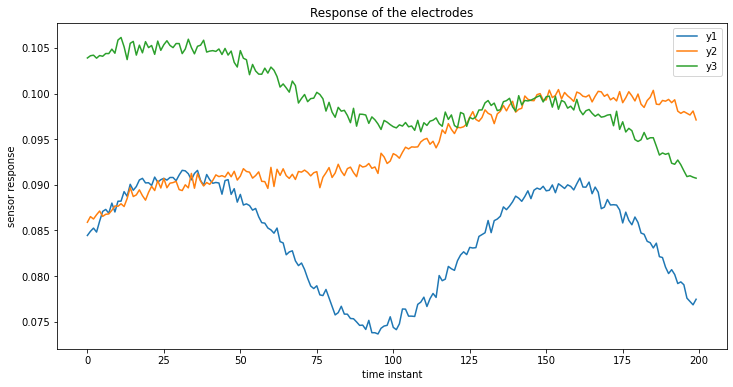

In [262]:
s_mean = 0
s_sigma = 0.5
noise_sigma = 0.0005
EE = np.matmul(e, np.ones((1, num_samples)))
DD = np.diag(np.array(d).T[0])
SS = S_comb #+ np.random.lognormal(mean=-10, sigma=s_sigma, size=(3,num_points))
Y = EE + np.matmul(DD , np.log10(np.matmul(AA, SS)))
Y_obs = Y + np.random.normal(loc=0, scale=noise_sigma, size=Y.shape)

print('E shape: ', EE.shape)
print('D shape: ',DD.shape)
print('Y shape: ', Y.shape)
plt.figure(figsize=(12,6))
plt.plot(Y_obs.T)
plt.xlabel('time instant')
plt.ylabel('sensor response')
plt.title("Response of the electrodes")
plt.legend(['y1','y2','y3'])

#### We will subsample the above complete data to get the training data.
Our goal is to use these subsample data to then pridict the activity values any given time.

idx : [  9  21  36  47  67 103 117 172 192 195]


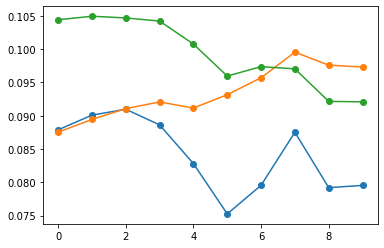

In [247]:
#random subsample the above data to get the training data
#use 10 samples to train
np.random.seed(0)
num_obs = 10
idx = np.sort(np.random.randint(low=0, high=num_samples-1, size=num_obs))
x = SS[:,idx]
y = Y_obs[:,idx]
print('idx :', idx)
a = plt.plot(y.T, marker='o')

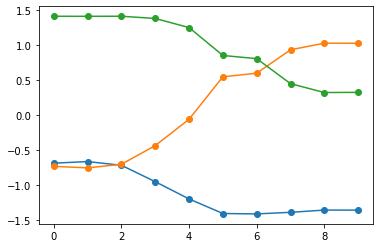

In [248]:
#Standardize the data
scaler = StandardScaler()
scaled_y = scaler.fit_transform(y)
scaler_mean = scaler.mean_
scaler_std = np.sqrt(scaler.var_)
a=plt.plot(scaled_y.T, marker='o')

In [78]:
scaler.mean_
scaler_std

array([0.00799921, 0.00757716, 0.00682801, 0.00685123, 0.00722011,
       0.0096775 , 0.00807749, 0.00517125, 0.00762532, 0.00813809])

### Implement the model and sample 

In [113]:
import theano as tt
samples = 2000
tune = 1000
with pm.Model() as model:
  #prior for E and D standard devs
  sigma_E = 0.02*pm.HalfNormal('sigma_E', sigma=1)
  sigma_D = 0.02*pm.HalfNormal('sigma_D', sigma=1)

  #prior for E
  temp_E1 = pm.Normal('temp_E1', mu=0, sigma=1, shape=(1,num_electrodes))
  E1 =  pm.Deterministic('E1', 0.1 + sigma_E*temp_E1)
  E = pm.Deterministic('E', pm.math.dot(E1.T, np.ones((1,num_obs))))
  
  #prior for D
  diag = tt.shared(np.diag(np.ones(num_electrodes)))
  temp_D1 = pm.Normal('temp_D1', sigma=1, shape=(1,num_electrodes))
  m = pm.math.dot(temp_D1.T, np.ones((1,num_electrodes)))
  D1 = diag*m
  D = pm.Deterministic('D', 0.055*diag + sigma_D*D1)
 
  #prior for A
  temp_A = pm.Uniform('temp_A', lower=0, upper=1, shape=(num_electrodes,num_sources))
  a1 = np.ones((num_electrodes,num_sources))
  np.fill_diagonal(a1, 0)
  a2 = np.zeros((num_electrodes,num_sources))
  np.fill_diagonal(a2, 1)
  diag1 = tt.shared(a1)
  diag2 = tt.shared(a2)
  temp_A1 = pm.Deterministic('temp_A1', temp_A*a1)
  A = pm.Deterministic('A', temp_A1 + a2)

  #prior for std dev of likelihood
  sigma_temp= pm.HalfNormal('sigma_temp', sigma=1)
  sigma = pm.Deterministic('sigma', 125*sigma_temp)

  #y_mean = E + pm.math.dot(D, np.log10(pm.math.dot(A, x))) 
  y_mean = (E + pm.math.dot(D , np.log10(pm.math.dot(A, x))) - scaler_mean)/scaler_std
  obs = pm.Normal('obs', mu=y_mean, sigma=sigma, observed=scaled_y) #likelihood
  
  #obs = pm.StudentT('obs', nu=2, mu=y_mean, sigma=sigma, observed=y)
  #start = pm.find_MAP()
  #prior_checks = pm.sample_prior_predictive(samples=50)
  trace0 = pm.sample(samples, tune=tune, chains=2, cores=1, target_accept=0.99)




C:\Users\16177\AppData\Local\Temp/ipykernel_10564/1408317204.py:37: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace0 = pm.sample(samples, tune=tune, chains=2, cores=1, target_accept=0.99)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_temp, temp_A, temp_D1, temp_E1, sigma_D, sigma_E]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 708 seconds.
The number of effective samples is smaller than 25% for some parameters.


The sampler above did an ok job. There were no divergences but the effective samples were small. We can either smaple more data or find another parameterization for the model to get better sampling. We will look at the posterior plots below.

C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
C:\Users\16177\anaco

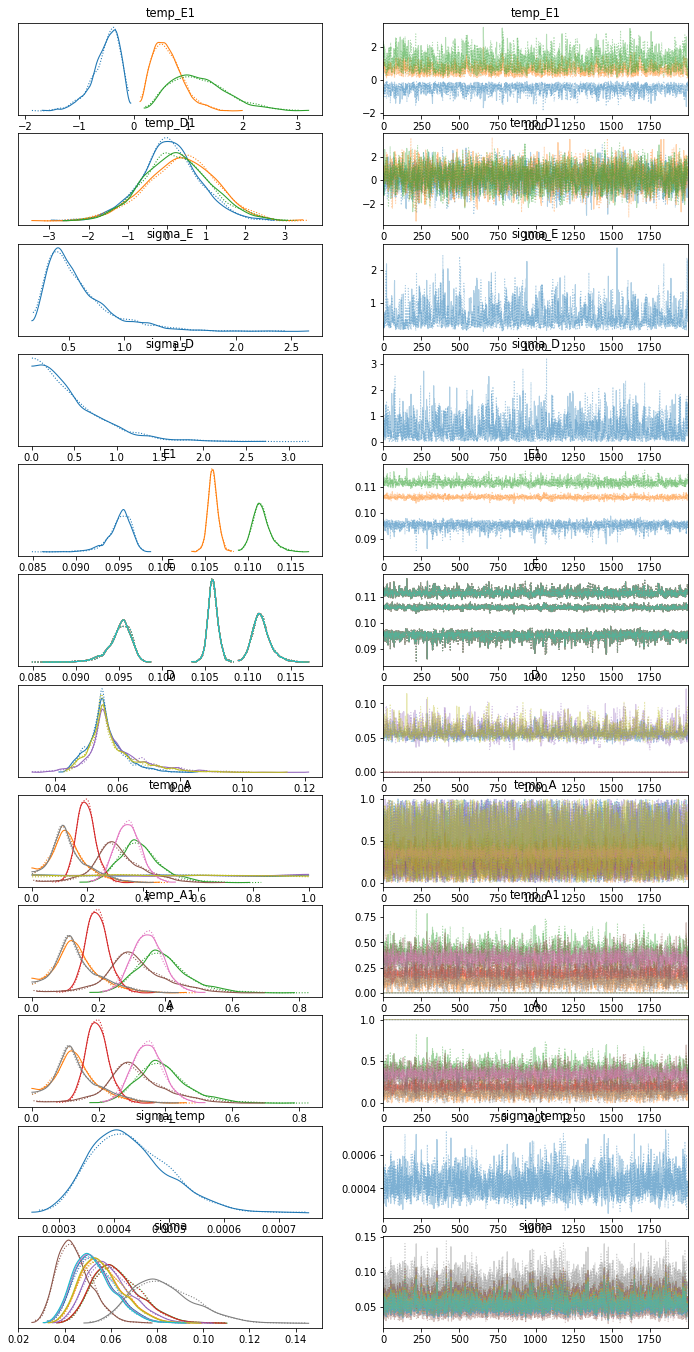

In [114]:
with pm.Model():
    pm.plot_trace(trace0)

The posterior plots above look good. They are allpeaked around the most probable values of the parameters. The trace on the right also looks random and does not have any snakey patters which means that the random walk was very much random. So our samples are good.

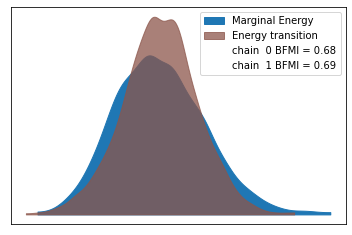

In [249]:
#the energy plot also looks good. 
#The closer the two distributions are the better the sampling. Our is close enough.
with model:
    az.plot_energy(trace0, figsize=(6,4))

Let's now sample from the posterior. This will give us the distribution of likely parametere that will explain the data.

In [115]:
with model:
  post_pred = pm.sample_posterior_predictive(trace0, var_names=['A','E','D','obs'])

In [116]:
D_hat = post_pred['D']
A_hat = post_pred['A']
E_hat = post_pred['E']

Compare the mean of the parameter distribution for each parameter and see how close to the actual parameter values they are. In our case they are pretty close. This shows that wour sampling was successful.

In [251]:
print(A_hat.mean(axis=0))   #these are close enough

[[1.         0.13162065 0.39102349]
 [0.19601749 1.         0.30789989]
 [0.34625235 0.13412763 1.        ]]


In [250]:
print(AA)

[[1.   0.16 0.4 ]
 [0.25 1.   0.19]
 [0.4  0.13 1.  ]]


In [118]:
D_hat.mean(axis=0)  #these are close enough

array([[0.05604369, 0.        , 0.        ],
       [0.        , 0.05932444, 0.        ],
       [0.        , 0.        , 0.05835959]])

In [252]:
DD

array([[0.059, 0.   , 0.   ],
       [0.   , 0.05 , 0.   ],
       [0.   , 0.   , 0.055]])

In [119]:
E_hat.mean(axis=0)[:,0] #these values are spot on to true values

array([0.09506856, 0.10591235, 0.11155901])

In [120]:
EE[:,0]

array([0.095, 0.105, 0.11 ])

Now using the A,d,e and y values we can predict the s values for all time observation from the complete data. we can invert the relation: 
<br>
<br>
$Y = E\cdot \mathbf{1}_{1\times n_d} + diag(d)log(AS)$

as

$S = A^{-1} 10^{D^{-1}(Y-E)} $     $\quad$     where, $D=diag(d), E = E\cdot \mathbf{1}_{1\times n_d}$


In [176]:
S_new = []
for i in range(4000):
    E_new = E_hat[0,:,1].reshape(3,1)*np.ones((3,200))
    D_new = D_hat[i]
    A_new = A_hat[i]
    S_new.append(np.matmul(np.linalg.inv(A_new), 10**(np.matmul(np.linalg.inv(D_new),(Y_obs-E_new)))))



Text(0.5, 0.98, 'Top: predicted results with 95% credible interval   Bottom: actual activity values')

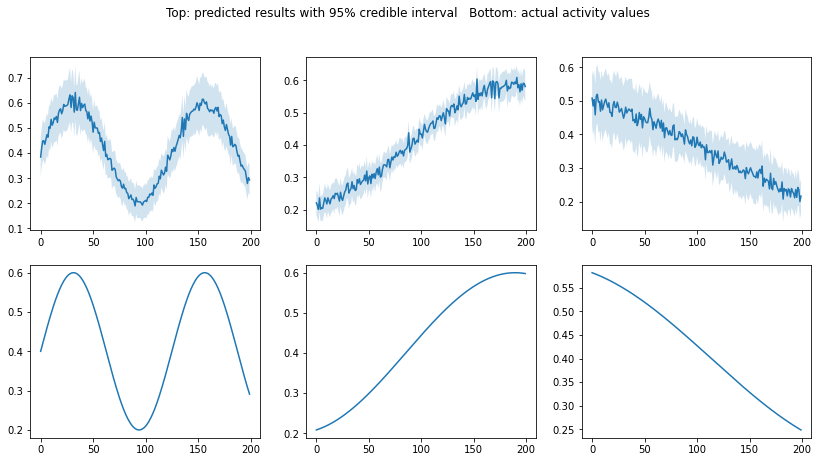

In [261]:
S_new = np.array(S_new)
S_mean = S_new.mean(axis=0)
S_std = S_new.std(axis=0)
fig, ax = plt.subplots(2,3, figsize=(14,7))
ax[0][0].plot(S_mean[0])
ax[0][0].fill_between(np.arange(num_samples), S_mean[0]+S_std[0]*2, S_mean[0]-S_std[0]*2, alpha=0.2)
ax[0][1].plot(S_mean[1])
ax[0][1].fill_between(np.arange(num_samples), S_mean[1]+S_std[1]*2, S_mean[1]-S_std[1]*2, alpha=0.2)
ax[0][2].plot(S_mean[2])
ax[0][2].fill_between(np.arange(num_samples), S_mean[2]+S_std[2]*2, S_mean[2]-S_std[2]*2, alpha=0.2)
ax[1][0].plot(S_comb[0])
ax[1][1].plot(S_comb[1])
ax[1][2].plot(S_comb[2])
fig.suptitle('Top: predicted results with 95% credible interval   Bottom: actual activity values')

The figure above looks good. With only 10 traing points we were able to get a pretty good approximation of actual activity for all other times. The more points we choose, the more accurate the predictions are going to be. But getting more points, especially more values of s is expensive. A person has to manully measure the activity without disturbing the solution(which is difficult: how do you measure the concentraion of an ion in a solution without affecting the solution?)

Measuring the electrode responses is cheap. So, can we get the same approximation using only the y values? We will explore that in the unsupervised approach to the problem.